## Human-informed vs. algorithmic feature weighting
This notebook examines the tradeoffs between human-informed weighting, and algorithmically learned weights in k-means clustering.

The experiment highlights a fundamental tension between data-driven optimization and stakeholder-aligned insights, especially while designing algorithms for human-centered applications.

We also explore a key difference between the data-driven and human definitions of *importance*:
- Humans define importance relatively, and often unpredictably
- FWSA mechanism defines a feature's importance by how efficiently it minimizes cluster dispersity
- Do these definitions ever align?


In [1]:
import torch
import numpy as np
import pandas as pd
from feature_definitions import ranking_features, survey_features
from util import plot_clusters

## Data pre-processing
Complete:
- Transform non-numerical survey features
- Normalize features to [0,1] with min-max scaling

Next steps:
- Transform categorical features to one-hot

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

full_ranking_data = pd.read_csv('Housing_factors.csv')
full_survey_data = pd.read_csv('Housing_survey.csv')

survey_data = full_survey_data[survey_features]
# display(key_survey_data)

scaler = MinMaxScaler()   # normalize features to [0,1]
imputer = SimpleImputer(strategy='most_frequent')  # replace NaN values

X = survey_data.to_numpy()
X_filled = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_filled)

survey_data = pd.DataFrame(X_scaled, columns=survey_data.columns)
display(survey_data)
print(X_scaled.shape)

,Latitude,Longitude
0,0.308623,0.010410
1,0.337995,0.000000
2,0.395371,0.627902
3,0.310649,0.007465
4,0.310649,0.007465
5,0.337995,0.000000
6,0.307563,0.007546
7,0.647185,1.000000
8,1.000000,0.001687
9,0.307563,0.007546


(14, 2)


## Fuzzy K-means clustering
As a baseline, we take the performance of k-means using the unweighted dispersion between samples and cluster centroids.
- All features are weighted **uniformly**
- We can use Euclidean distance or sum of squared distances to measure dispersion

Inertia (sum of squared distances): 0.013005394577885574


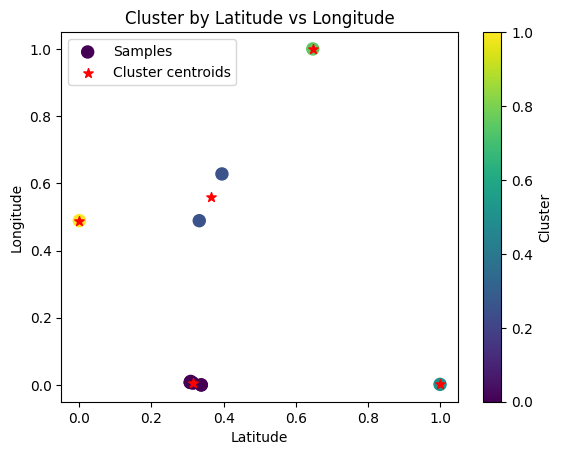

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

print(f"Inertia (sum of squared distances): {kmeans.inertia_}")
plot_clusters(X_scaled, survey_features, labels, centers, "Latitude", "Longitude")

## Feature weighted K-means
To cluster, we measure **distortion** between two data samples. There are cases in which applying a uniform, unweighted distortion across all features doesn't make sense:
- We don't expect the statistical distributions of different features to be the same (Modha and Spangler, 2003); therefore, distortions on individual components are allowed to be different.
- All features aren't equally important.

To encode this, we can redefine distortion to be a weighted sum of the distortions between individual component feature vectors. We extend the fuzzy k-means optimization algorithm to employ this weighted distortion measure.

#### User-informed feature weights
We derive our weights by taking the average user-informed importance ranking for each feature

In [4]:
rank_data = full_ranking_data[ranking_features]

W = np.nanmean(rank_data.to_numpy(), axis=0)
W = 5 - W + 1   # max-based inversion: original ranks are 1 (most) to 5 (least) significant

rank_data = pd.DataFrame(W.reshape(1, -1), columns=survey_features)
display(rank_data)
print(W.shape)

,Latitude,Longitude
0,3.163043,3.163043


(2,)


Inertia (sum of squared distances): 0.13011694450022782


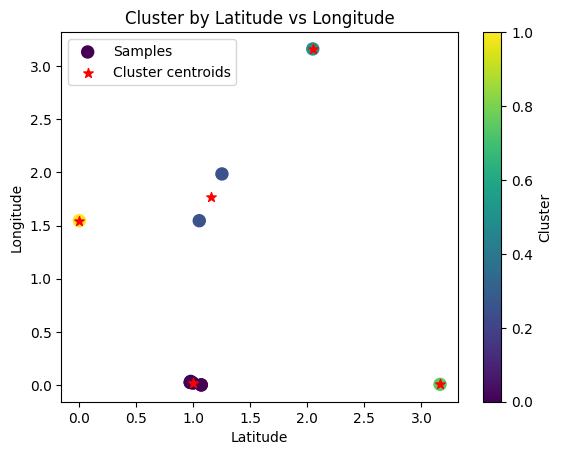

In [5]:
X_weighted = X_scaled * W

kmeans.fit(X_weighted)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

print(f"Inertia (sum of squared distances): {kmeans.inertia_}")
plot_clusters(X_weighted, survey_features, labels, centers, "Latitude", "Longitude")

#### Algorithmically learned feature weights
An optimal feature weighting minimizes the average within-cluster dispersion, while simultaneously *maximizing* the average between-cluster dispersion across all feature spaces.
- In English, we want samples of the same cluster closer to cluster centers, and cluster centers far apart
- We weigh features based on how clearly they seperate clusters (e.g., no clear separation gets lower weight)

#### Feature weight self-adjustment (FWSA) mechanism
Genereally, the K-means algorithm treats all features fairly (weights features equally) when evaluating dissimilarity. FWSA differs in the following ways:
- At each iteration of K-means, all feature weights are adaptively updated by adding their respective adjustment margins (Tsai and Chiu, 2008).
- The **adjustment margin** of a feature weight is derived from the importance of the feature to the overall clustering quality.
- A feature's weight adjustment is inversely proportional to its dispersion (how scattered it is across clusters)

#### Feature-reduction fuzzy c-means clustering (FRFCM)
- Similar to FWSA, in FRFCM we drive down the weights of unimportant features
- Low-weight features are ultimately discarded during clustering

## Evaluation
We evaluate the two approaches based on several quantitative and qualitative metrics.

**Quantitative**
1.   Within-cluster sum of squared distances
2. Silhouette score: measures within-cluster compactness and between-cluster separation
3.   Convergence time: iterations until centroids stop moving significantly or cluster assignments stop changing
  - If we use our human-informed cluster centroids as a basis for the data-driven k-means optimization, can we improve convergence time?
  - What happens when we mix interpretability and data-driven refinement?

**Qualitative**
1. Interpretability: do the clusters reflect meaningful groupings?
  - Examine the mean feature values and standard deviations for each cluster
  - Do subjects of the same cluster value a particular feature more than others? (less variance from the mean)
2. Human evaluation: do the results line up with what we expect?
  - For each weighting approach, we do the following:
    - Fit k-means (estimate centroids) to the training data
    - Assign the test data to clusters
    - Run a simulation: assign users to a test cluster and have them evaluate the accuracy of their own recommendations
